# Doug Devens webscraping project
## Efficacy of sail racing handicapping in the Detroit-Mackinac race

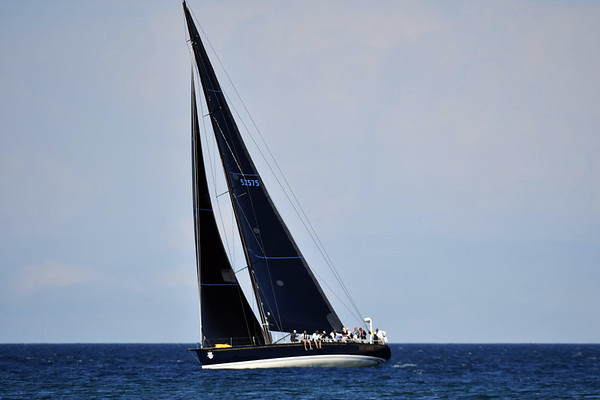

## Background and Purpose
This project examines the efficacy of the sail racing handicap system by examining a single race, [the Bayview Yacht Club's Detroit-Mackinac race](https://www.bycmack.com/) (pronounced *mak-in-aw*) up the eastern shore of Michigan on Lake Huron, over a period of time.  This race allows many types of sailboats and uses the [Offshore Racing Rule](https://offshoreracingrule.org/) (ORR) to compensate for differences in boat design.  This rule, like its predecessor the [International Racing Certificate](https://en.wikipedia.org/wiki/IRC_(sailing)) (IRC) handicaps (or increases the adjusted finished time upward from the actual elapsed race time) larger, faster boats and adjusts downward the times for smaller, slower sailboats.  It is the adjusted time after the application of this handicap that determines the overall race winner. To date it has been generally accepted (see the [FAQ](https://bermudarace.com/bermuda-race-faqs-the-orr/) in the Newport-Bermuda race) that the handicapping system is impartial.  Understanding and using the ORR affects the design and fitting of these large sailboats (like the one pictured above) that can cost at least several hundred thousand dollars, so understanding if there are potential weaknesses in the system may affect decisions to spend large sums of money.

## Analytical Approach
We examine the efficacy of the ORR by comparing the performance of boats of different ORR handicaps against their finish time after application of the handicap.  It is this adjusted finish time that determines order of finish in the race.  If the ORR handicap system were to work as intended there would be no relationship between finish time and the adjusted finish time, meaning all types and sizes of sailboats have an equal chance of winning.  Here the dependent variable or observed variable is the adjusted finish time (after correction of the actual elapsed time with the handicap, where a negative handicap means time is added to the elapsed time to obtain the adjusted finish time.)  *Larger sailboats with more sail area generally trend toward negative handicap times.*  The independent variables or features are: handicap time adjustment, race year, divison (denoting which course the entrant took since there are two courses, and a separate division for multihull/catamaran entrants since the ORR system differently to those boats), the boat class (design type.)  Descriptive variables for each entrant include the sail number and the boat name.

## Data Tools
The Github repository for this project is [devens-mn/Devens_NYCDSA_Web_Scrape](https://github.com/devens-mn/Devens_NYCDSA_Web_Scrape.git).  The file contains copies of the the script used to generate the data from the race website, the script used to clean, prepare them for analysis and merge the datafiles and a copy of this jupyter notebook.

### Webscraping
The race website goes back to 1996, but the format has changed at least twice over the years, in 2002 and 2019.  We have scraped from 2002 through 2019, though for now that required two scripts. That also required we include a merge of those two files in our cleaning script in order to perform analysis.  The format was also dynamic, which required use of Selenium to gather the data.  The webscraping script is *detmackrace.py* and it generates *detmacraceresults.csv*.

### Data preparation
The data gathered from the website few typing errors.  There were no missing values, and there was only 1 time value that showed evidence of mistyping.  Sailboats that don't finish due to rules infractions or withdraw before or during the race received "DNF", *Did Not Finish*; "DNS", *Did Not Start* and "Retired", in their time columns and these require removal for further analysis. The cleaning script creates duplicate columns of numeric data with NaN where disqualification codes had been in the elapsed time and adjusted finish time columns.  It also winsorizes the data, removing an outlier that I was later able to determine had been mistyped.  Finally the script creates *sail_data.csv* and *sail_data_winsor.csv* (not winsorized and winsorized, respectively) to read in as a dataframe in the graphical analysis.

## Analysis
The approach to data analysis that I use was one I learned as ***PGA***, or Practical - Graphical - Analytical.  The first step, Practical, is to find missing or anomalous data, which was performed by the cleaning script.  The second step, commenced below, is to perform a graphical analysis of the data. Using insights from the graphical analysis I can focus my analysis using statistical functions on particularly interesting areas. 

### Graphical analysis
For graphical analysis I use matplotlib and Seaborn.

I first put in autoreload into the notebook so I can use an external module of fxns to perform the analysis.

In [1]:
%load_ext autoreload
%autoreload 2

Load the cleaning fxns from the Detmacrace_clean module.

In [2]:
from Detmacrace_clean import * 

Load the analysis functions from the detmac_analysis_fxns module.

In [3]:
from detmac_analysis_fxns import *

Load the csv file created by the scraping script, and create versions with numerical columns and a winsorized version to eliminate mistyped outliers.  A description of the columns, their meaning and type of data in each column are in Sailing_data_dictionary.txt in the repository.

In [4]:
sail_data, sail_data_winsor = clean_fxn('detmacraceresults.csv')

/Users/doug/opt/python_in_class/Selenium/Devens_NYCDSA_Web_Scrape/Devens_NYCDSA_Web_Scrape/Detmacrace_clean.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sail_data_winsor['Division_only'] = sail_data_winsor['Division_course'].str.slice(0,12)


The first task is to examine the distribution of the handicap times for each entry in all the race generated by the ORR system, to see if there are any particular trends visible or if there is evidence of multimodality with a histogram.  My personal experience with datasets this size (here nearly 3700 observations) leads me to believe a test for normality such as the Anderson-Darling will show the data are likely from a non-normal distribution.  Since the normality assumption is only an approximation, the small confidence intervals afforded by large datasets often show the assumption to be violated.  As a reminder, negative handicaps are for larger, faster boats that have time *added* to their elapsed times.  We see that the handicap times appear rougly normally distributed, with some evidence of left skew and potentially evidence of kurtosis.

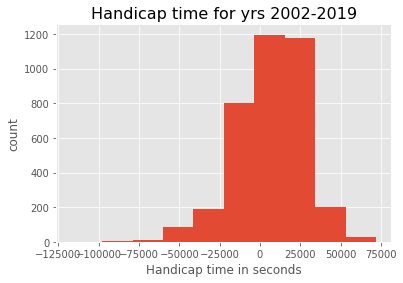

In [5]:
histo_plot(sail_data_winsor, 'Handicap time')

Here we determine if there are trends by Division (described above) in the handicap time.  We observe no practically significant trend between divisons, with the possible exception of Division V, the multihull division.

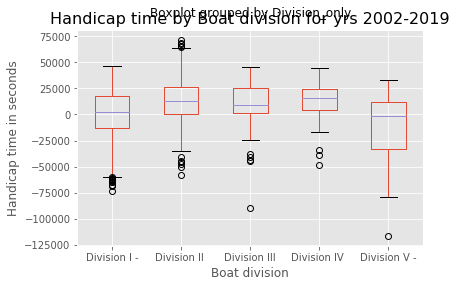

In [6]:
sail_box_plot(sail_data_winsor, 'Handicap time', 'Boat division')

With no clear trends in handicap time as a function of boat division, we visualize the relationship between the handicap time and the adjusted finish time for all divisions. We observe no obvious relationship, and note the cluster of points in the lower right of the graph.

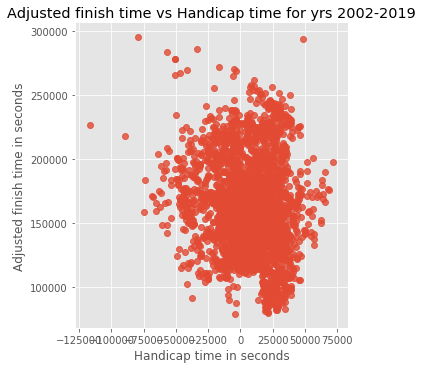

In [7]:
sail_scttr_plot(sail_data_winsor, 'Handicap time', 'Adjusted finish time')

We replot the handicap time vs adjusted finish time grouping the plotted data by race year. Trends vary across years, but some of the seaborn lmplot lines indicate a relationship between the handicap time and the adjusted finish time. It also appears that cluster in the lower right, of particularly fast adjusted finish times for boats that had handicaps allowed them to subtract time from their elapsed times, was from boats racing in 2017.

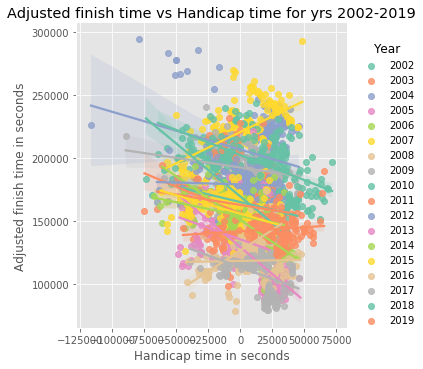

In [8]:
sail_scttr_plot(sail_data_winsor, 'Handicap time', 'Adjusted finish time','Year', True)

The graph of the adjusted finish times by year indicates significant differences between years.  We import stats from scipy to confirm this significance with an ANOVA test between several years.  We chose 2016, 2007 and 2010 as example years.  I have not checked that the data are normally distributed (though they appear to be close I already suspect underlying relationships that could violate the assumption) nor have equal variance, so caution must be applied to this analysis.  However, the p-value less than 10^-13 leads me to believe that the same would be true for a less powerful comparison of median values.

In [9]:
sail_anva_byyr(sail_data_winsor, 'Handicap time', 2016, 2007, 2010)

F_onewayResult(statistic=32.89465924556544, pvalue=2.994565140049243e-14)


Here I replot the same data, grouping by boat division. Trends vary by division it seems none of the trends are particularly powerful (meaning practically significant) with the potential exception of Division 5 which has a different application of the ORR rule.

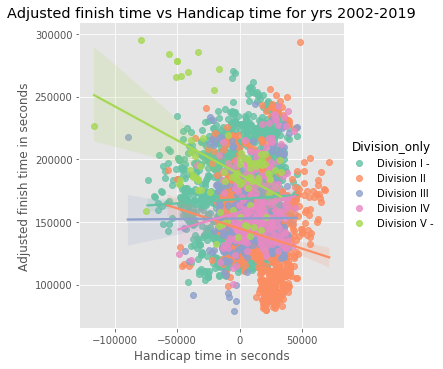

In [10]:
sail_scttr_plot(sail_data_winsor, 'Handicap time', 'Adjusted finish time','Boat division', True)

In the visualization so far there has been no particularly significant trend visible, with the exception of by year.  To increase the potential of seeing an effect of a more homogenous population, we focus on a single division (Division 1, recently the race by Cove Island off the Canadian shore of Lake Huron and the only division that has been consistently monohulls) and again group data by year. We observe a relationship of increasing adjusted finish time as a function of handicap time for division 1 sailboats over multiple years.

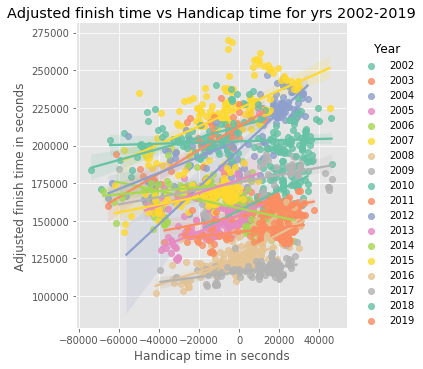

In [11]:
sail_scttr_plot_sbst(sail_data_winsor, 'Handicap time', 'Adjusted finish time',\
    'Boat division', 'Division I -', Sbslc2 = None, Sbslc2val = None, by_column='Year', lmfit=True)

Here we look at only division 1 for just 2016, and there is clearly a trend of increasing adjusted finish time as the handicap goes from negative (which larger boats would have) toward positive (which smaller boats would have.)  This implies that larger sailboats are not having their finish times adjusted upwards enough to compensate for their inherent advantages over smaller sailboats.

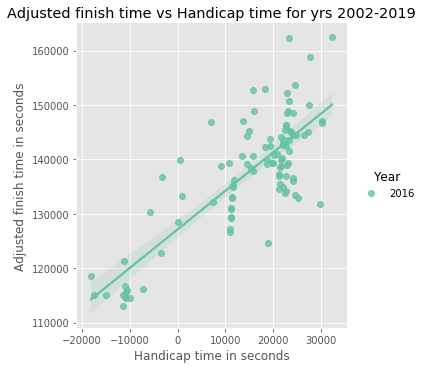

In [12]:
sail_scttr_plot_sbst(sail_data_winsor, 'Handicap time', 'Adjusted finish time',\
    'Boat division', 'Division I -', Sbslc2 = 'Year', Sbslc2val = 2016, by_column='Year', lmfit=True)

The trend for 2012 has a comparable trend, with one cluster at higher handicap times and adjusted finish times, and another at lower handicap times and lower adjusted finish times.

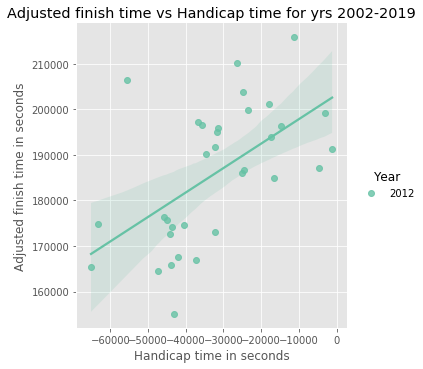

In [13]:
sail_scttr_plot_sbst(sail_data_winsor, 'Handicap time', 'Adjusted finish time',\
    'Boat division', 'Division I -', Sbslc2 = 'Year', Sbslc2val = 2012, by_column='Year', lmfit=True)

The trend for 2004 is more driven by high-leverage outliers with negative handicaps but the correlation nevertheless appears significant.

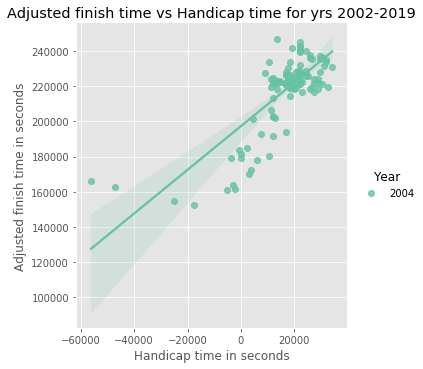

In [14]:
sail_scttr_plot_sbst(sail_data_winsor, 'Handicap time', 'Adjusted finish time',\
    'Boat division', 'Division I -', Sbslc2 = 'Year', Sbslc2val = 2004, by_column='Year', lmfit=True)

The Division 1 results for 2013 appear to have much less dependence on the handicap time, that may be driven by the cluster of boats with handicaps of appproximately -12,000 sec finishing with a wide range of adjusted times, all below the predicted value.

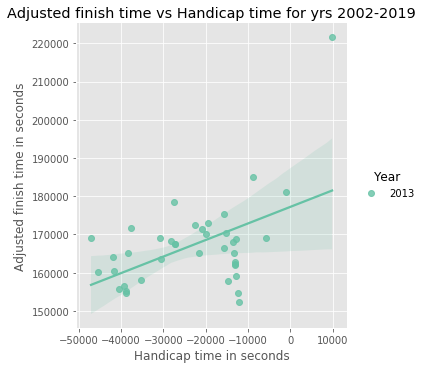

In [15]:
sail_scttr_plot_sbst(sail_data_winsor, 'Handicap time', 'Adjusted finish time',\
    'Boat division', 'Division I -', Sbslc2 = 'Year', Sbslc2val = 2013, by_column='Year', lmfit=True)

### Quantitative analysis
We have observed visually what appear to be significant relationships between handicap time and adjusted finish time in at least two years, with a less significant relationship in other years.  We wrote a script using scikitlearn's regression function over the period 2002 through 2018 to determine if there was a relationship between adjusted finish time and handicap time for each of the years in the period.  This script will produce a list of tuples of (year, r-value) where the r-value is the average of a sample of 50 iterations.  I found that one or two iterations may produce wide variation in the r-value, but from the central limit theorem a sample of 50 iterations should produce a relatively stable estimate of the r-value.

We plot the r-values between the handicap time and the adjusted finish time as a function of year for the period examined.  We see the r-value is in the upper 50% range for 2004, around 40% for 2011 and around 60% for 2016.  The only years where there is are likely significant negative correlations are 2013 and 2014.  In all of the other years there is either a weakly positive correlation or no correlation.

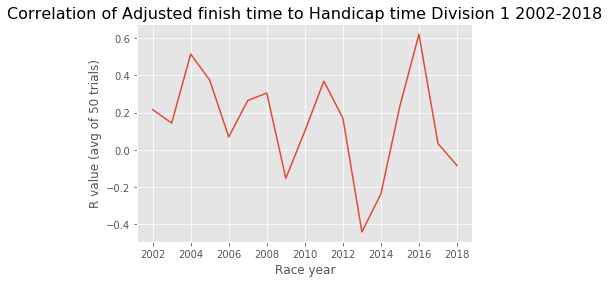

In [16]:
yr_rgrss_fxn(sail_data_winsor, 'Handicap time', 'Adjusted finish time', 50)

I noticed that 2016's average finish time was relatively fast, at about 135,000 sec or about 38 hours, compared to about 60 hours for other years.  I had hypothesized the relationship may be due to a failing of the ORR handicap rule's failure to account for the effects of wind speed (a faster windspeed from anywhere except the north could cause a faster race velocity.)  I plotted average finish time for each year for Division 1 to examine that hypothesis.  In this analysis 2004 and 2011 are relatively slow years with adjusted finish times around 56 hours, and 2016 at 38 hours.  Race speed doesn't appear to be the significant factor.

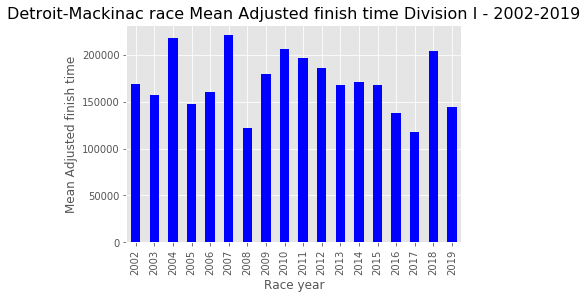

In [17]:
mean_by_div(sail_data_winsor, 'Division I -', 'Adjusted finish time')

I hypothesized other non-weather factors could explain the variation.  First I examined the number of entries across all divisions by year, for a baseline since I intended to examine the number of disqualifications per year.

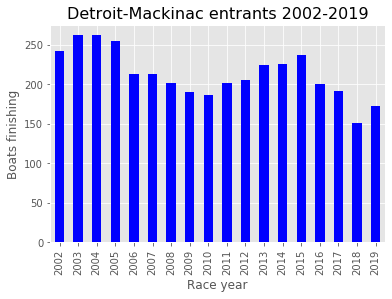

In [18]:
entry_count(sail_data)

I examined the number of Did Not Finish entries for each year, since DNF is entered when an entrant withdraws for non-rule-related reasons, most often equipment failure (*e.g* dismasting or rudder failure.)  Clearly 2004 was a year with a large number of DNFs, but a review of the [race history part](https://www.bycmack.com/history/Mackinac_Race_History_2004_2008.pdf) of their website shows confirms that 2004 was a slow year, due to very light winds.  They don't examine DNFs directly, but I assume these were boats that withdrew because they didn't enjoy the very slow sailing and they had no chance of winning.  There doesn't appear to be a strong correlation since 2016 had no DNFs and 2011 had only a few.

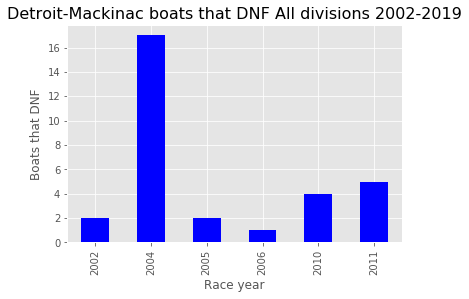

In [19]:
disqual_count(sail_data, 'DNF')

I also questioned if there were rule-infraction-related reasons for the correlations, and examined the number of "Retired"s for each year.  There doesn't appear to be a strong relationship between the "Retired"s and the r-value between the handicap time and the adjusted finish time.

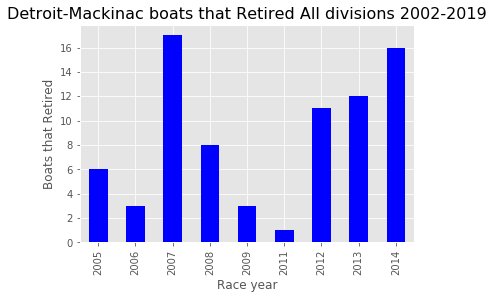

In [20]:
disqual_count(sail_data, 'Retired')

## Conclusion
I have found that the handicapping system doesn't appear to be working as intended, in that it appears to favor larger, faster boats that are already advantaged in racing.  This difference in 2016 alone was about 8 hrs and 20 minutes, in a year when the difference between first and tenth places was about 50 seconds of adjusted time.  The amount accounted for by the bias in the system can clearly be significant. 

However, I haven't determined why this relationship is occurring.  The fact that it appears to happen in some years but not in others led me to assume that weather may be causing it, but there is no obvious correlation between race time (as a proxy for windspeed) and the appearance of that correlation.  It could be other meteorological phenomena such as wind direction, since it is well known that some sailboats perform better "upwind" (sailing nearly toward the wind) than others simply by design.  The ORR racing system is quite complex, taking into account many [boat design parameters](https://docs.google.com/spreadsheets/d/1f132iq6z7KuaFqIv6kHM4bdFkQ5nWM35KZQOzLzV4ZM/edit?usp=sharing), and the IRC in fact is literally a black-box, never having been published.  I don't know now if the ORR system accounts for factors such as "upwind" speed.

### Future work
One obvious direction would be to gather more weather data for Lake Huron on the race dates in question.  One could scrape these data from the National Weather Service website with more research.  Another area of research, to see if this phenomenon is more general, would be to examine a similar set of data from the Chicago-Mackinac race since that is also an inland body of water.  Similarly, since the Newport-Bermuda race is an oceanic where weather conditions tend to be more constant, we can see if there is less yearly variation.